In [71]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import imblearn
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import time

Loading the training and test data.

In [72]:
train_df = pd.read_csv('train_small.csv', header=None)
test_df = pd.read_csv('test_small.csv')

Generating new features and adding them to the dataset.

In [73]:
idx = features = train_df.columns.values[2:202]
train_df['sum'] = train_df[idx].sum(axis=1)  
train_df['min'] = train_df[idx].min(axis=1)
train_df['max'] = train_df[idx].max(axis=1)
train_df['mean'] = train_df[idx].mean(axis=1)
train_df['std'] = train_df[idx].std(axis=1)
train_df['skew'] = train_df[idx].skew(axis=1)
train_df['kurt'] = train_df[idx].kurtosis(axis=1)
train_df['med'] = train_df[idx].median(axis=1)

The data is split into training and test data. We are careful to split the set before we do imbalance correction.

In [79]:
num_training_samples = 40000
train_targets = train_df.iloc[:num_training_samples,1]
train_data = train_df.iloc[:num_training_samples,2:]
test_targets = train_df.iloc[num_training_samples:,1]
test_data = train_df.iloc[num_training_samples:,2:]

# Organise the data into numpy arrays so that it is handled correctly by imblearn
nump_train_data = train_data.to_numpy()
nump_train_data = nump_train_data.astype(float)
nump_train_targets = train_targets.to_numpy()
nump_train_targets = nump_train_targets.astype(int)

nump_test_data = test_data.to_numpy()
nump_test_data = nump_test_data.astype(float)
nump_test_targets = test_targets.to_numpy()
nump_test_targets = nump_test_targets.astype(int)

Due to the imbalanced data set, we try balance it using SMOTE and random undersampling.

Removed indexes: [ 9562 21148 19783 ... 39974 39987 39988]


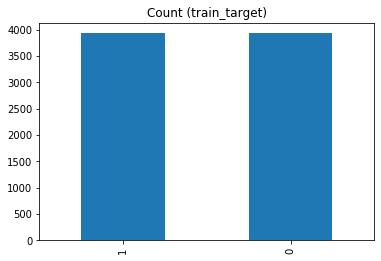

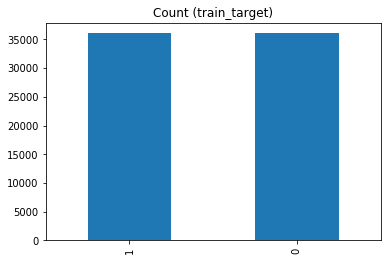

In [85]:
rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='auto',return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(nump_train_data, nump_train_targets)

smote = SMOTE(ratio='minority',  k_neighbors=40)
X_sm, y_sm = smote.fit_sample(nump_train_data, nump_train_targets)

print('Removed indexes:', id_rus)

plt.figure(1)
df_rus = pd.DataFrame(X_rus)
df_rus['train_target'] = y_rus
df_rus.train_target.value_counts().plot(kind='bar', title='Count (train_target)');

plt.figure(2)
df_sm = pd.DataFrame(X_sm)
df_sm['train_target'] = y_sm
df_sm.train_target.value_counts().plot(kind='bar', title='Count (train_target)');

We compare SMOTE, random undersampling and the unbalanced training set.

In [86]:
dtrain = xgb.DMatrix(X_sm, label=y_sm)
dtest = xgb.DMatrix(nump_test_data, label=nump_test_targets)

start = time.time()

param = {'max_depth':3, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 1000
model = xgb.train(param, dtrain, num_round)

end = time.time()
print(end - start)

preds = model.predict(dtest)
roc = roc_auc_score(test_targets, preds)
print("AUC: %.4f%% " % (roc * 100))

473.6923899650574
AUC: 77.8880% 


In [82]:
dtrain = xgb.DMatrix(X_rus, label=y_rus)
dtest = xgb.DMatrix(nump_test_data, label=nump_test_targets)

start = time.time()

param = {'max_depth':3, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 1000
model = xgb.train(param, dtrain, num_round)

end = time.time()
print(end - start)

preds = model.predict(dtest)
roc = roc_auc_score(test_targets, preds)
print("AUC: %.4f%% " % (roc * 100))

39.46702480316162
AUC: 84.6634% 


In [83]:
dtrain = xgb.DMatrix(train_data, label=train_targets)
dtest = xgb.DMatrix(test_data, label=test_targets)

start = time.time()

param = {'max_depth':3, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 1000
model = xgb.train(param, dtrain, num_round)

end = time.time()
print(end - start)

preds = model.predict(dtest)
roc = roc_auc_score(test_targets, preds)
print("AUC: %.4f%% " % (roc * 100))

242.732848405838
AUC: 83.8846% 
